The following is a simple backtest of a betting strategy based on the Kelly criteron. I'll try to compare different ratios of the criterion and see which has the best returns.

This experiment is inspired by the following [paper](http://www.edwardothorp.com/wp-content/uploads/2016/11/KellySimulationsNew.pdf)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('epl_odds.csv')

The columns we need are:
- FTR - Full time result (either **H**ome or **A**way)
- AvgH - average odds for the home team to win
- AvgA - average odds for the away team to win
- AvgD - average odds for a draw

In [3]:
#o_cols = ['FTR', 'AvgH', 'AvgA', 'AvgD']
o_cols = ['FTR', 'B365H', 'B365A', 'B365D']
df = df.filter(o_cols)

Assume we start with a balance of $100.

The strategy is to pick the outcome with the highest probability (lowest odds) and place Kelly bets on the outcome.

In [7]:
def run_kelly(k_factor, can_plot):
    starting_bal = 100
    bal = starting_bal
    bet = 0

    bal_history = np.empty(len(df))
    result_history = [None]*len(df)

    outcomes = ['H', 'A', 'D']
    for i, row in df.iterrows():
        all_odds = row.drop('FTR')
        idx = np.argmin(all_odds) + 1

        odds = row[idx]

        p = 1/odds

        bet = (p + (p-1)/odds)*k_factor

        bet_amt = bet*bal
        bal -= bet_amt
        if row['FTR'] == outcomes[idx-1]:
            bal += bet_amt*odds
            result_history[i] = 'g'
        else:
            result_history[i] = 'r'

        bal_history[i] = bal

        if bal <= 0:
            break
            
    def generate_plots():
        fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [9, 1], 'hspace': 0})

        axs[0].plot(bal_history)

        for i, col in enumerate(result_history):
            axs[1].scatter(i, -2, c=col, marker='|', linewidths=[0.8])

        axs[1].axes.get_yaxis().set_visible(False)
        axs[1].axes.get_xaxis().set_visible(False)
        plt.show()

        print(f"Final balance of ${bal:.2f} with a maximum of ${max(bal_history):.2f}")

    if can_plot:
        generate_plots()
    
    return bal

Plot for a Kelly factor of 0.01


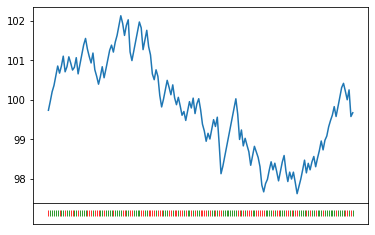

Final balance of $99.67 with a maximum of $102.13
Plot for a Kelly factor of 0.12


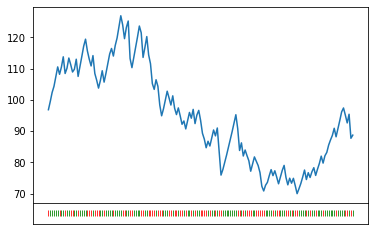

Final balance of $88.71 with a maximum of $126.90
Plot for a Kelly factor of 0.23


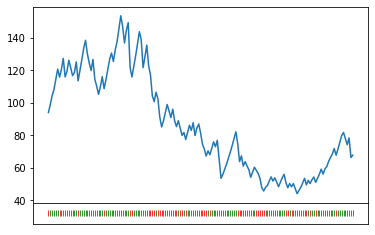

Final balance of $67.70 with a maximum of $153.54
Plot for a Kelly factor of 0.34


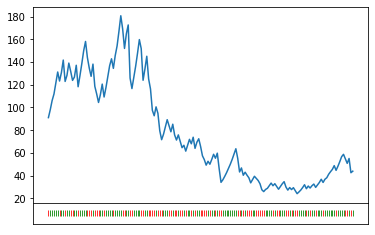

Final balance of $43.86 with a maximum of $180.85
Plot for a Kelly factor of 0.45


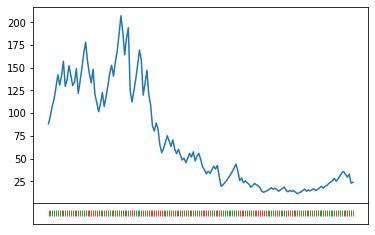

Final balance of $23.77 with a maximum of $207.26
Plot for a Kelly factor of 0.56


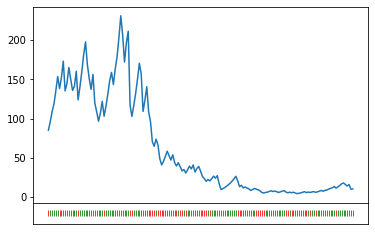

Final balance of $10.58 with a maximum of $230.96
Plot for a Kelly factor of 0.67


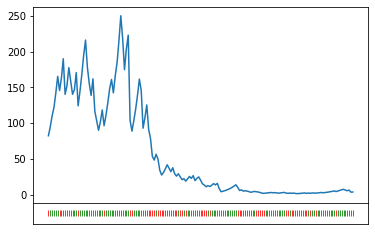

Final balance of $3.77 with a maximum of $250.04
Plot for a Kelly factor of 0.78


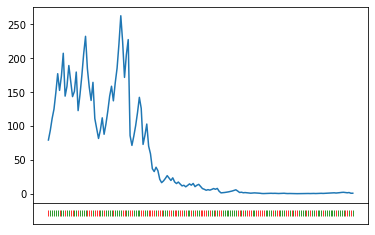

Final balance of $1.03 with a maximum of $262.65
Plot for a Kelly factor of 0.89


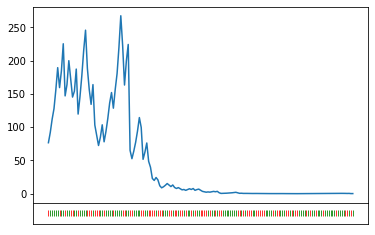

Final balance of $0.20 with a maximum of $267.32
Plot for a Kelly factor of 1.00


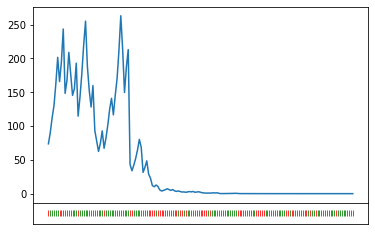

Final balance of $0.03 with a maximum of $263.09


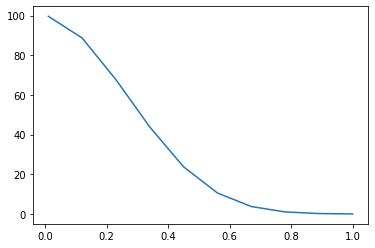

In [8]:
factors = np.linspace(0.01, 1, 10)
bals = np.empty(len(factors))

for i in range(len(factors)):
    print(f"Plot for a Kelly factor of {factors[i]:.2f}")
    bals[i] = run_kelly(factors[i], True)

plt.plot(factors, bals)